In [2]:
import os
import pickle
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import glob

In [3]:
# === Config ===
ROOT_DIR = "/data/maddie/vjepa2/data/demos/coffee_table/world_model_eval"  # folder with scene_* subdirs
CAMERA_ARG = 2            # can be int (index into camera_names) or str (exact camera name)
RESIZE = (256, 256)       # training image resolution
BATCH_SIZE = 8
NUM_EPOCHS = 5
LR = 1e-4
CAMERA_NAME= "rear_camera" # rearleft_camera, rearright_camera, rear_camera, topdown_camera
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)


Device: cuda


In [ ]:


pickle_paths = sorted(glob.glob(os.path.join(ROOT_DIR, "scene_*", "*.pickle")))
print(f"Found {len(pickle_paths)} pickle files.")
print("First few:")
for p in pickle_paths[:5]:
    print(" -", p)


def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

sample_path = pickle_paths[0]
sample = load_pickle(sample_path)

print("Top-level keys:", list(sample.keys()))
print("Video keys:", list(sample["video"].keys()))
print("Camera names:", sample["video"]["camera_names"])

# Inspect a single frame for each camera
for cname in sample["video"]["camera_names"]:
    fr = sample["video"]["frames"][cname][0]
    arr = np.array(fr)
    print(f"{cname}: shape={arr.shape}, dtype={arr.dtype}")
print(sample['video']['ee_states'])



Found 35 pickle files.
First few:
 - /data/maddie/vjepa2/data/demos/coffee_table/world_model_eval/scene_0/1754378146.pickle
 - /data/maddie/vjepa2/data/demos/coffee_table/world_model_eval/scene_0/1754378171.pickle
 - /data/maddie/vjepa2/data/demos/coffee_table/world_model_eval/scene_0/1754378198.pickle
 - /data/maddie/vjepa2/data/demos/coffee_table/world_model_eval/scene_0/1754378225.pickle
 - /data/maddie/vjepa2/data/demos/coffee_table/world_model_eval/scene_0/1754378277.pickle
Top-level keys: ['base', 'video']
Video keys: ['ee_states', 'frames', 'fps', 'camera_names']
Camera names: ['rearleft_camera', 'rearright_camera', 'rear_camera', 'topdown_camera']
rearleft_camera: shape=(1, 512, 512, 3), dtype=uint8
rearright_camera: shape=(1, 512, 512, 3), dtype=uint8
rear_camera: shape=(1, 512, 512, 3), dtype=uint8
topdown_camera: shape=(1, 512, 512, 3), dtype=uint8


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# Your short resize with the necessary squeeze:
def resize_image(img_array, size=(256, 256)):
    arr = np.asarray(img_array)
    if arr.ndim == 4 and arr.shape[0] == 1:  # (1,H,W,3) -> (H,W,3)
        arr = arr[0]
    assert arr.ndim == 3 and arr.shape[2] == 3, f"Unexpected shape {arr.shape}"
    img_pil = Image.fromarray(arr.astype(np.uint8))
    return np.array(img_pil.resize(size, resample=Image.Resampling.BILINEAR))

# resize one file for santity check
sample_path = pickle_paths[0]
sample = load_pickle(sample_path)

raw = sample["video"]["frames"][CAMERA_NAME][0]   # shape (1,H,W,3)
print("raw shape:", np.asarray(raw).shape)

resized = resize_image(raw, size=RESIZE)          # your squeeze+resize function
print("resized shape:", resized.shape)

raw shape: (1, 512, 512, 3)
resized shape: (256, 256, 3)


In [ ]:
import os, glob, pickle, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

ROOT_DIR    = "/data/maddie/vjepa2/data/demos/coffee_table/world_model_eval"
CAMERA_NAME = "rear_camera"            # <- you said you want rear camera
RESIZE      = (256, 256)
BATCH_SIZE  = 8
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"

def safe_load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def resize_image(img_array, size=(256, 256)):
    arr = np.asarray(img_array)
    if arr.ndim == 4 and arr.shape[0] == 1:   # (1,H,W,3) -> (H,W,3)
        arr = arr[0]
    assert arr.ndim == 3 and arr.shape[2] == 3, f"Unexpected shape {arr.shape}"
    img_pil = Image.fromarray(arr.astype(np.uint8))
    return np.array(img_pil.resize(size, resample=Image.Resampling.BILINEAR))

class TeleopFrameDataset(Dataset):
    def __init__(self, root_dir, camera_name="rear_camera", resize=(256,256), max_per_file=None, device='cuda'):
        self.device = device
        self.resize = resize
        self.entries = []  # list of (pickle_path, frame_idx)
        for p in sorted(glob.glob(os.path.join(root_dir, "scene_*", "*.pickle"))):
            data = safe_load_pickle(p)
            # if camera_name not in data["video"]["camera_names"]:
            #     continue
            frames = data["video"]["frames"][camera_name]
            n = len(frames) if max_per_file is None else min(len(frames), max_per_file)
            for t in range(n):
                self.entries.append((p, t))
        print(f"Dataset entries: {len(self.entries)}")

    def __len__(self): return len(self.entries)

    def __getitem__(self, i):
        p, t = self.entries[i]
        data = safe_load_pickle(p)
        images = torch.tensor(resize_image(data["video"]["frames"][CAMERA_NAME][t]), device=self.device)
        states = torch.tensor(data['video']['ee_states'][t], device=self.device)
        actions = torch.as_tensor(
        data["base"]["actions"][int(round(t * data["base"]["sim_freq"] / data["video"]["fps"]))],
                dtype=torch.float32, device=self.device
            ).view(1, 1, 7)  # [1,1,7]
        x = {
            'image': images,
            'states': states,
            'actions': actions,
        }
        return x

ds = TeleopFrameDataset(ROOT_DIR, CAMERA_NAME, resize=RESIZE, max_per_file=None, device=DEVICE)  # set a small number while testing if you want
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
batch = next(iter(dl))



Dataset entries: 1598
T: 11


/tmp/ipykernel_325147/3188019266.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(data['video']['ee_states'][t], device=self.device)


T: 21
T: 37
T: 30
T: 40
T: 1
T: 4
T: 1


In [23]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

encoder, _ = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")
encoder = encoder.to(DEVICE).eval()

patch_size       = encoder.patch_size
tokens_per_side  = 256 // patch_size            # assuming you resized to 256
tokens_per_frame = tokens_per_side**2
embed_dim        = encoder.embed_dim

print(f"patch_size={patch_size}, tokens_side={tokens_per_side}, tokens={tokens_per_frame}, D={embed_dim}")
assert 256 % patch_size == 0, "Resize must be divisible by patch size."


Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main
/home/maddie/.conda/envs/vjepa2/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


patch_size=16, tokens_side=16, tokens=256, D=1408


In [31]:
@torch.no_grad()
def images_to_tokens(images):  # images: [B,3,256,256]
    # Build [B, C, T, H, W] with T=2 (repeat the same frame)
    print(f'Dtype of images: {images.dtype}')
    x = images.unsqueeze(2).repeat(1, 1, 2, 1, 1)   # [B, 3, 2, 256, 256]
    # No permute here!
    assert x.shape[1] == 3 and x.shape[2] == 2, f"Got {x.shape}, expected [B,3,2,H,W]"
    tkns = encoder(x)                                # [B, 2*Ts*Ts, D]
    return tkns[:, -tokens_per_frame:, :]            # [B, Ts*Ts, D] (last frame)


In [25]:
import math, numpy as np
import torch.nn as nn

class TokenGridDecoder(nn.Module):
    def __init__(self, embed_dim, tokens_side, out_res=256, base_ch=512):
        super().__init__()
        self.proj = nn.Conv2d(embed_dim, base_ch, kernel_size=1)

        layers, ch = [], base_ch
        steps = int(np.log2(out_res // tokens_side))  # e.g., 16->32->64->128->256
        for _ in range(steps):
            layers += [nn.ConvTranspose2d(ch, ch//2, 4, 2, 1), nn.ReLU(inplace=True)]
            ch //= 2
        layers += [nn.Conv2d(ch, 3, 3, 1, 1), nn.Sigmoid()]
        self.up = nn.Sequential(*layers)

    def forward(self, tokens):               # tokens: [B, N, D]
        B, N, D = tokens.shape
        S = int(math.sqrt(N))
        z = tokens.transpose(1, 2).reshape(B, D, S, S)  # [B, D, S, S]
        z = self.proj(z)
        return self.up(z)                     # [B, 3, 256, 256]

decoder = TokenGridDecoder(embed_dim, tokens_per_side, out_res=256).to(DEVICE)


In [37]:
batch = next(iter(dl))     # dl is your DataLoader
print("Batch size:", batch['image'].shape)
images = batch['image'].permute(0, 3, 1, 2).to(torch.float)           # [B, 3, 256, 256]
with torch.no_grad():
    tkns = images_to_tokens(images)    # [B, Ts*Ts, D]
    preds = decoder(tkns)             # [B, 3, 256, 256]
print("tokens:", tkns.shape, "preds:", preds.shape)


T: 29


/tmp/ipykernel_325147/3188019266.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(data['video']['ee_states'][t], device=self.device)


T: 40
T: 30
T: 17
T: 16
T: 34
T: 23
T: 34
Batch size: torch.Size([8, 256, 256, 3])
Dtype of images: torch.float32
tokens: torch.Size([8, 256, 1408]) preds: torch.Size([8, 3, 256, 256])


/home/maddie/.conda/envs/vjepa2/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


/home/maddie/.conda/envs/vjepa2/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Epoch 1: loss=0.0057


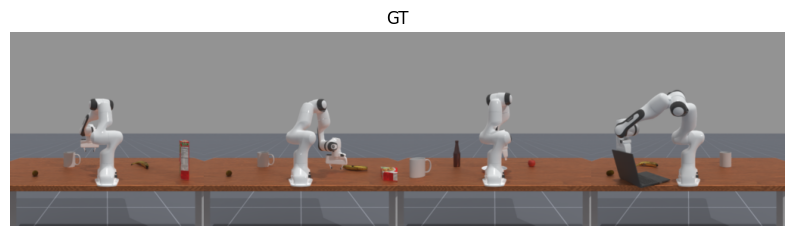

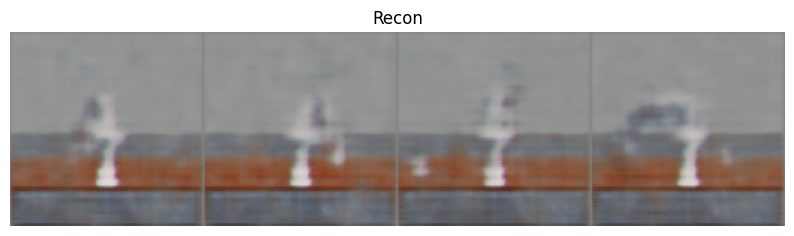

Epoch 2: loss=0.0017


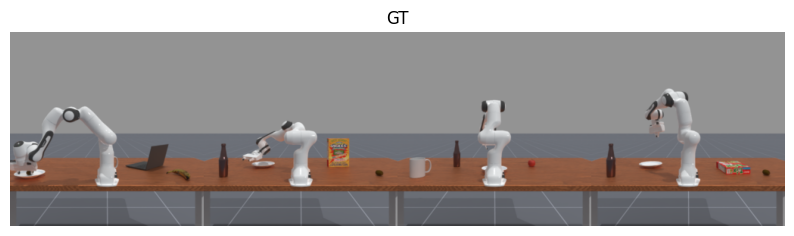

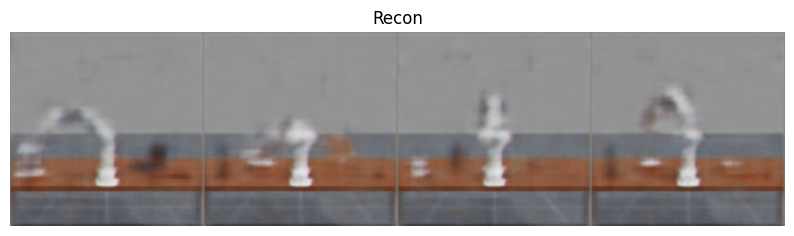

Epoch 3: loss=0.0012


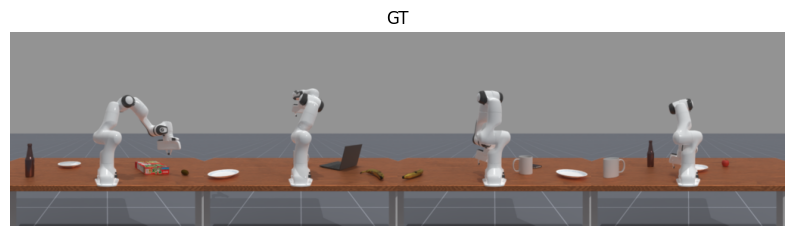

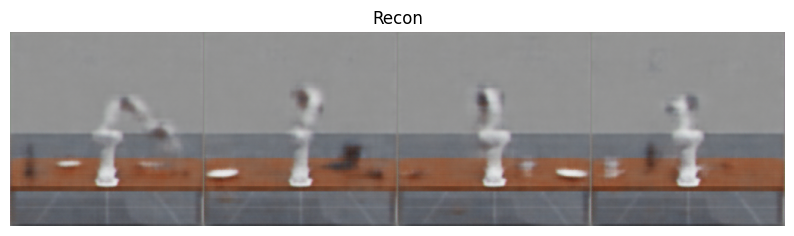

Epoch 4: loss=0.0010


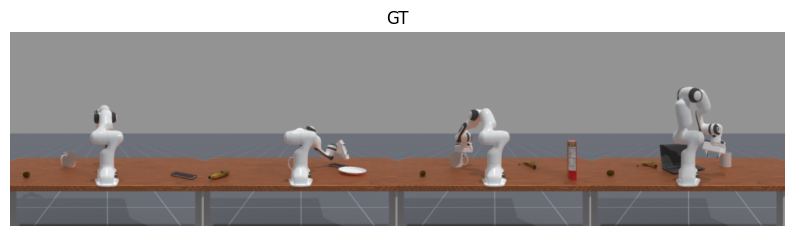

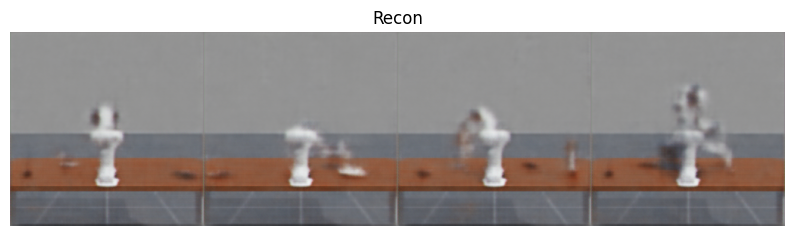

Epoch 5: loss=0.0009


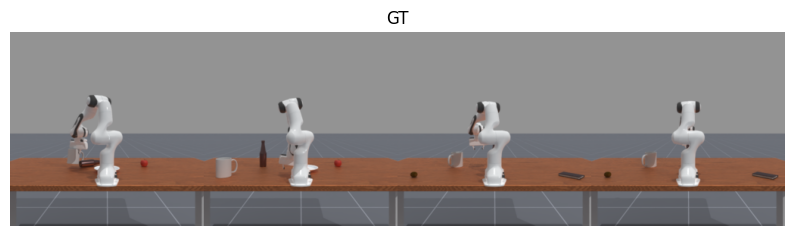

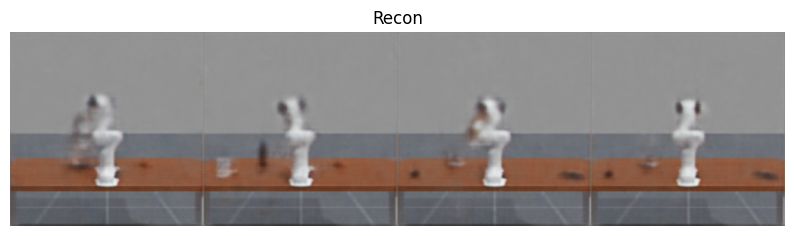

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

opt = torch.optim.Adam(decoder.parameters(), lr=1e-4)

def show_row(imgs, title):
    b = min(imgs.size(0), 4)
    row = torch.cat([imgs[i] for i in range(b)], dim=2).permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(10,3)); plt.imshow(row); plt.axis('off'); plt.title(title); plt.show()

NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    decoder.train()
    running = 0.0
    for images in dl:
        images = images.to(DEVICE)
        with torch.no_grad():                      # encoder is frozen
            tkns = images_to_tokens(images)        # [B, 256, 1408]
        recon = decoder(tkns)                      # [B, 3, 256, 256]
        loss  = F.mse_loss(recon, images)

        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item()

    avg = running / max(1, len(dl))
    print(f"Epoch {epoch+1}: loss={avg:.4f}")

    # quick viz

    
    decoder.eval()
    with torch.no_grad():
        images = next(iter(dl)).to(DEVICE)
        preds  = decoder(images_to_tokens(images))
    show_row(images, "GT")
    show_row(preds,  "Recon")

    torch.save(decoder.state_dict(), f"decoder_epoch{epoch+1}.pth")


In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

opt = torch.optim.Adam(decoder.parameters(), lr=1e-4)

def show_row(imgs, title):
    b = min(imgs.size(0), 4)
    row = torch.cat([imgs[i] for i in range(b)], dim=2).permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(10,3)); plt.imshow(row); plt.axis('off'); plt.title(title); plt.show()

NUM_EPOCHS = 8
for epoch in range(NUM_EPOCHS):
    decoder.train()
    running = 0.0
    for images in dl:
        images = images.to(DEVICE)
        with torch.no_grad():                      # encoder is frozen
            tkns = images_to_tokens(images)        # [B, 256, 1408]
        recon = decoder(tkns)                      # [B, 3, 256, 256]
        loss  = F.l1_loss(recon, images)

        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item()

    avg = running / max(1, len(dl))
    print(f"Epoch {epoch+1}: loss={avg:.4f}")

    # quick viz
    decoder.eval()
    with torch.no_grad():
        images = next(iter(dl)).to(DEVICE)
        preds  = decoder(images_to_tokens(images))
    show_row(images, "GT")
    show_row(preds,  "Recon")

    torch.save(decoder.state_dict(), f"decoder_epoch{epoch+1}.pth")
